Necessary Imports:

    1. requests: To send HTTP requests to Spotify API.

    2. pandas: Data processing to analyze streaming history.

    3. matplotlib and seaborn: Data visualization.

    4. webbrowser: To automatically open the browser.

    5. http.server: To set up a local HTTP server for Spotify's OAuth authentication.

    6. threading: To run the HTTP server in the background.

    7. base64: To encrypt API keys.

    8. time and datetime: To perform operations related to time.

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import webbrowser
from http.server import HTTPServer, BaseHTTPRequestHandler
import urllib.parse
import json
import threading
import base64
import time
from datetime import datetime

Defining Spotify API Information

    1. CLIENT_ID and CLIENT_SECRET: Credentials required for Spotify API access.

    2. REDIRECT_URI: URL to return after authorization.

    3. AUTH_CODE: A global variable for the authorization code to be received from the user.

In [14]:
CLIENT_ID = "client_id"  
CLIENT_SECRET = "client_secret_id" 
REDIRECT_URI = "http://localhost:8888/callback"
AUTH_CODE = None

AuthHandler Class:

    This class receives the authorization code from Spotify:
        After the user logs in to the browser, Spotify sends the authorization code via the specified REDIRECT_URI.
        The code is stored in the global AUTH_CODE variable.

In [4]:
class AuthHandler(BaseHTTPRequestHandler):
    def do_GET(self):
        global AUTH_CODE
        if '/callback' in self.path:
            query_components = urllib.parse.parse_qs(urllib.parse.urlparse(self.path).query)
            AUTH_CODE = query_components['code'][0]
            self.send_response(200)
            self.send_header('Content-type', 'text/html')
            self.end_headers()
            self.wfile.write(b"Authorization successful! You can close this window.")
            threading.Thread(target=self.server.shutdown).start()


Running Server:
    
    This function starts a local HTTP server using the AuthHandler class.

In [5]:
def start_auth_server():
    server = HTTPServer(('localhost', 8888), AuthHandler)
    server.serve_forever()

User Authorization Process:

    1. Opens a browser tab to get an authorization code from Spotify.
    2. After the user logs in and grants permission, the AUTH_CODE is received.

In [6]:
def get_user_auth():
    server_thread = threading.Thread(target=start_auth_server)
    server_thread.daemon = True
    server_thread.start()

    scope = "user-library-read user-read-private"
    auth_params = {
        'client_id': CLIENT_ID,
        'response_type': 'code',
        'redirect_uri': REDIRECT_URI,
        'scope': scope,
        'show_dialog': 'true'
    }
    
    auth_url = "https://accounts.spotify.com/authorize?" + urllib.parse.urlencode(auth_params)
    print("Opening browser for authorization...")
    webbrowser.open(auth_url)
    
    while AUTH_CODE is None:
        time.sleep(0.1)
    
    return AUTH_CODE


Getting Access Token:

    1. Spotify sends authorization code to API.
    2. Returns access token (this token is required to pull data from API).

In [7]:
def get_access_token(auth_code):
    token_url = "https://accounts.spotify.com/api/token"
    credentials = base64.b64encode(f"{CLIENT_ID}:{CLIENT_SECRET}".encode()).decode()
    
    headers = {
        "Authorization": f"Basic {credentials}",
        "Content-Type": "application/x-www-form-urlencoded"
    }
    
    data = {
        "grant_type": "authorization_code",
        "code": auth_code,
        "redirect_uri": REDIRECT_URI
    }
    
    response = requests.post(token_url, headers=headers, data=data)
    if response.status_code == 200:
        return response.json()["access_token"]
    else:
        print(f"Error getting access token: {response.json()}")
        return None


Loading and Analyzing Streaming History:

    1. Streaming history is read from JSON file.
    2. endTime column is converted to datetime format.
    3. Time zones such as month, hour are added.
    4. msPlayed column is converted to minutes.

A. Loading JSON data

In [8]:
def load_streaming_history(file_path):
    df = pd.read_json(file_path)
    df['endTime'] = pd.to_datetime(df['endTime'])
    df['date'] = df['endTime'].dt.date
    df['hour'] = df['endTime'].dt.hour
    df['month'] = df['endTime'].dt.to_period('M')
    df['minutes_played'] = df['msPlayed'] / (1000 * 60)
    return df


B. Monthly Most Listened Songs

    1. Songs are grouped by month.
    2. The longest listened song is selected for each month.

In [9]:
def get_monthly_top_songs(df):
    monthly_tracks = df.groupby(['month', 'trackName', 'artistName'])['minutes_played'].sum().reset_index()
    monthly_top_songs = monthly_tracks.loc[monthly_tracks.groupby('month')['minutes_played'].idxmax()]
    return monthly_top_songs

Mood analysis is done based on the song's popularity, genre and duration.

In [10]:
def analyze_track_features(track_details):
    genres = track_details.get('album', {}).get('genres', [])
    popularity = track_details.get('popularity', 0)
    duration_ms = track_details.get('duration_ms', 0)

    mood_keywords = {
        'happy': ['pop', 'dance', 'disco'],
        'energetic': ['rock', 'metal', 'punk', 'electronic'],
        'calm': ['ambient', 'classical', 'jazz'],
        'melancholic': ['blues', 'soul'],
        'intense': ['rap', 'hip hop', 'trap']
    }
    mood_scores = {mood: 0 for mood in mood_keywords.keys()}
    for genre in genres:
        for mood, keywords in mood_keywords.items():
            if any(keyword in genre for keyword in keywords):
                mood_scores[mood] += 1

    if popularity > 75:
        mood_scores['energetic'] += 1
        mood_scores['happy'] += 1
    elif popularity < 25:
        mood_scores['melancholic'] += 1

    if duration_ms > 360000:
        mood_scores['intense'] += 1
    elif duration_ms < 180000:
        mood_scores['energetic'] += 1

    dominant_mood = max(mood_scores.items(), key=lambda x: x[1])[0]
    if all(score == 0 for score in mood_scores.values()):
        dominant_mood = 'balanced'
    
    return {
        'dominant_mood': dominant_mood,
        'popularity': popularity,
        'duration_ms': duration_ms,
        'mood_scores': mood_scores
    }


Visualization of Data
1. Mood Visualization

In [11]:
def create_mood_visualization(df_analysis):
    """
    Create a visualization of song moods
    """
    plt.figure(figsize=(15, 8))

    # Create color mapping for moods
    mood_colors = {
        'happy': '#2ecc71',     # Green
        'energetic': '#e74c3c', # Red
        'intense': '#8e44ad',   # Purple
        'melancholic': '#3498db', # Blue
        'balanced': '#f1c40f'    # Yellow
    }

    # Create the bar plot
    bars = plt.bar(range(len(df_analysis)), 
            [1] * len(df_analysis),
            color=[mood_colors.get(mood, '#95a5a6') for mood in df_analysis['dominant_mood']])

    # Customize the plot
    plt.xticks(range(len(df_analysis)), 
              df_analysis['trackName'], 
              rotation=45, 
              ha='right')
    plt.yticks([])  # Hide y-axis ticks

    # Add mood labels on the bars
    for idx, row in df_analysis.iterrows():
        plt.text(idx, 0.5, row['dominant_mood'].title(), 
                 ha='center', va='center', 
                 rotation=0,
                 color='black',
                 fontweight='bold')

    # Customize the layout
    plt.title('Mood Analysis of Your Most Listened Monthly Tracks', pad=20)
    plt.tight_layout()

    # Add a legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=mood.title()) 
                      for mood, color in mood_colors.items()]
    plt.legend(handles=legend_elements, 
              title='Mood Types',
              bbox_to_anchor=(1.15, 1),
              loc='upper right')

    plt.show()

Main Function:

    1. It executes all operations in order.
    2. Authorization, analysis of listening history, mood and duration graphs of songs are created.

Starting Spotify authorization process...
Opening browser for authorization...
Loading listening history...

Analyzing your music...

Analyzing: Count Me Out by Kendrick Lamar
Listening time: 52.68 minutes
Mood: Balanced
Popularity: 74/100


127.0.0.1 - - [10/Jan/2025 18:20:44] "GET /callback?code=AQD6DAS_Uv1jf-tcZH7I0_6dd5wOX_Tm-EvUF6rCS1wStBr2RIyK4hzyoxS6c9DXovJV7SGtIO2RNWsvd7sjGm8EI1bi8lJetKER7Q2FbbscACpe9iWOVqbE3kwuPqM2uOC5t9ZlnTIf9z7uEaQlI4GfMZ0fJEqBGXwMaLYv4ESF79rr95Y4nfFjaJLzYdTjvLW0zwYfdR1LTGzHRbCrWO-IxzdK0s1Q HTTP/1.1" 200 -



Analyzing: Yangın Akvaryum by Büyük Ev Ablukada
Listening time: 114.76 minutes
Mood: Intense
Popularity: 37/100

Analyzing: ELECTROWAVEBABY by Kid Cudi
Listening time: 134.95 minutes
Mood: Balanced
Popularity: 48/100

Analyzing: By Design by Kid Cudi
Listening time: 220.81 minutes
Mood: Balanced
Popularity: 55/100

Analyzing: sana.yazdım by Şam
Listening time: 86.30 minutes
Mood: Balanced
Popularity: 52/100

Analyzing: microdose by Motive
Listening time: 84.29 minutes
Mood: Energetic
Popularity: 44/100

Analyzing: PRIDE. by Kendrick Lamar
Listening time: 112.84 minutes
Mood: Happy
Popularity: 81/100

Analyzing: sen iste <3 by Yung Ouzo
Listening time: 330.10 minutes
Mood: Energetic
Popularity: 42/100

Analyzing: Kalbim Yanımda by Ati242
Listening time: 77.64 minutes
Mood: Energetic
Popularity: 69/100

Analyzing: Mr. Rager by Kid Cudi
Listening time: 102.75 minutes
Mood: Balanced
Popularity: 73/100

Analyzing: Mr. Rager by Kid Cudi
Listening time: 13.18 minutes
Mood: Balanced
Popularit

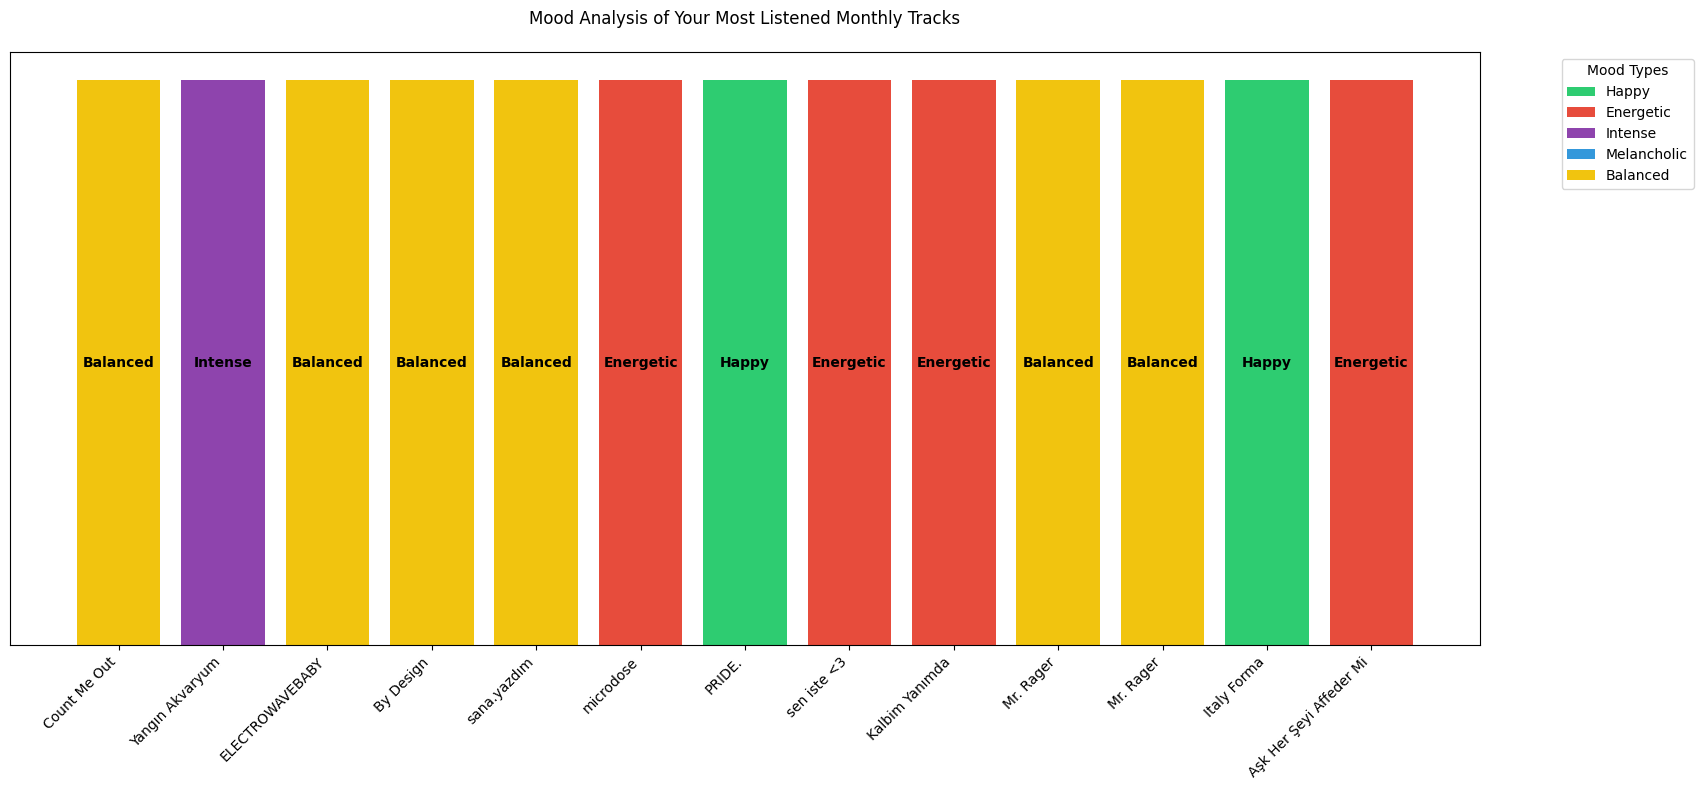

In [17]:
def main():
    try:
        # Get authorization and token
        print("Starting Spotify authorization process...")
        auth_code = get_user_auth()
        access_token = get_access_token(auth_code)
        
        if not access_token:
            print("Failed to get access token")
            return

        # Load listening history
        print("Loading listening history...")
        listening_history_path = "/Users/semihcelik/Desktop/dsa210 /Spotify_Data/StreamingHistory_music_0.json"
        df_history = load_streaming_history(listening_history_path)
        
        # Get monthly top songs using actual listening duration
        monthly_top_songs = get_monthly_top_songs(df_history)
        
        print("\nAnalyzing your music...")
        track_analyses = []
        headers = {"Authorization": f"Bearer {access_token}"}
        
        for _, row in monthly_top_songs.iterrows():
            query = f"track:{row['trackName']} artist:{row['artistName']}"
            search_url = f"https://api.spotify.com/v1/search?q={urllib.parse.quote(query)}&type=track&limit=1&market=TR"
            
            try:
                response = requests.get(search_url, headers=headers)
                if response.status_code == 200:
                    items = response.json()["tracks"]["items"]
                    if items:
                        track_id = items[0]["id"]
                        track_url = f"https://api.spotify.com/v1/tracks/{track_id}"
                        track_response = requests.get(track_url, headers=headers)
                        
                        if track_response.status_code == 200:
                            track_details = track_response.json()
                            analysis = analyze_track_features(track_details)
                            
                            print(f"\nAnalyzing: {row['trackName']} by {row['artistName']}")
                            print(f"Listening time: {row['minutes_played']:.2f} minutes")
                            print(f"Mood: {analysis['dominant_mood'].title()}")
                            print(f"Popularity: {analysis['popularity']}/100")
                            
                            analysis.update({
                                "Month": str(row["month"]),
                                "trackName": row["trackName"],
                                "artistName": row["artistName"],
                                "minutes_played": row["minutes_played"]
                            })
                            track_analyses.append(analysis)
                    else:
                        print(f"Track not found: {row['trackName']}")
                
                time.sleep(0.5)  # Rate limiting prevention
                
            except Exception as e:
                print(f"Error processing track: {str(e)}")
                continue
        
        if not track_analyses:
            print("No valid analysis data collected")
            return
            
        # Create DataFrame
        df_analysis = pd.DataFrame(track_analyses)
        
        # Save analysis
        output_path = "music_mood_analysis.csv"
        df_analysis.to_csv(output_path, index=False)
        print(f"\nAnalysis saved to {output_path}")
        
        # Print summary
        print("\nMonthly Music Mood Progression:")
        for _, row in df_analysis.sort_values('Month').iterrows():
            print(f"{row['Month']}: {row['trackName']} - {row['dominant_mood'].title()} ({row['minutes_played']:.2f} minutes)")
        
        print("\nMood Distribution:")
        mood_counts = df_analysis['dominant_mood'].value_counts()
        for mood, count in mood_counts.items():
            print(f"{mood.title()}: {count} tracks")

        # Create visualizations
        create_mood_visualization(df_analysis)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()